In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from torch import Tensor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from typing import Iterable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.colors import LinearSegmentedColormap
from joblib import dump, load

In [2]:
site = 'A'

In [3]:
import sys

# load the data
# get parent directory
os.chdir("../..")
data_directory = 'Data_clean'
data_name = site + '_data_clean.csv'

data = pd.read_csv(os.path.join(os.getcwd(), data_directory, data_name), index_col = 0)

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [4]:
# drop irrelevant columns
data = data.drop(columns = ['Wind_speed_sd'])

In [5]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'TI',
       'Temperature', 'Power'])

In [6]:
# load normalization function 
scaler1 = load('scaler1.bin')
scaler2 = load('scaler2.bin')

In [7]:
class Net(nn.Module):
    def __init__(self, dims: Iterable[int], output_activation: nn.Module = None):
        """Creates a network using ReLUs between layers and no activation at the end

        :param dims (Iterable[int]): tuple in the form of (IN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE2,
            ..., OUT_SIZE) for dimensionalities of layers
        :param output_activation (nn.Module): PyTorch activation function to use after last layer
        """
        super().__init__()
        self.input_size = dims[0]
        self.out_size = dims[-1]
        self.layers = self.make_seq(dims, output_activation)

    @staticmethod
    def make_seq(dims: Iterable[int], output_activation: nn.Module) -> nn.Module:
        """Creates a sequential network using ReLUs between layers and no activation at the end

        :param dims (Iterable[int]): tuple in the form of (IN_SIZE, HIDDEN_SIZE, HIDDEN_SIZE2,
            ..., OUT_SIZE) for dimensionalities of layers
        :param output_activation (nn.Module): PyTorch activation function to use after last layer
        :return (nn.Module): return created sequential layers
        """
        mods = []

        for i in range(len(dims) - 2):
            mods.append(nn.Linear(dims[i], dims[i + 1]))
            mods.append(nn.ReLU())

        mods.append(nn.Linear(dims[-2], dims[-1]))
        if output_activation:
            mods.append(output_activation())
        return nn.Sequential(*mods)
    
    def forward(self, x: Tensor) -> Tensor:
        """Computes a forward pass through the network

        :param x (torch.Tensor): input tensor to feed into the network
        :return (torch.Tensor): output computed by the network
        """
        # Feedforward
        return self.layers(x)


In [10]:
# load the trained weights
checkpoint_median = torch.load(sys.path[0] + '/median.pth')
checkpoint_UQ = torch.load(sys.path[0] + '/UQ.pth')
checkpoint_LQ = torch.load(sys.path[0] + '/LQ.pth')

# define network architecture 
net_median = Net(dims = (3, 16, 16, 16, 16, 1))
net_UQ = Net(dims = (3, 16, 16, 16, 16, 1))
net_LQ = Net(dims = (3, 16, 16, 16, 16, 1))

In [11]:
%%time
#################################################### predict ######################################################### 

turbines = data.instanceID.unique()
results = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # normalize data
    X = data_temp.iloc[:, 6:-1].values
    X = scaler1.transform(X)
    
    # load model based on turbine number
    net_median.load_state_dict(checkpoint_median[ID])
    net_UQ.load_state_dict(checkpoint_UQ[ID])
    net_LQ.load_state_dict(checkpoint_LQ[ID])

    # predict
    median = net_median(Tensor(X))
    median = scaler2.inverse_transform(median.detach().numpy()).flatten()
    UQ = net_UQ(Tensor(X))
    UQ = scaler2.inverse_transform(UQ.detach().numpy()).flatten()
    LQ = net_LQ(Tensor(X))
    LQ = scaler2.inverse_transform(LQ.detach().numpy()).flatten()

    data_temp = pd.concat([data_temp, pd.Series(median, index = data_temp.index.values, name = 'Predicted_power'), 
                           pd.Series(UQ, index = data_temp.index.values, name = 'UQ'), 
                           pd.Series(LQ, index = data_temp.index.values, name = 'LQ')], axis = 1)
    
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  A_WTG01
Done  A_WTG02
Done  A_WTG04
Done  A_WTG06
Done  A_WTG05
Done  A_WTG03
Wall time: 665 ms


In [12]:
results.head()

,ts,Month,Day,Hour,Week,instanceID,Wind_speed,TI,Temperature,Power,Predicted_power,UQ,LQ
0,2020-01-01 00:00:00,1,1,0,1,A_WTG01,3.625675,7.073759,1.643807,61.43359,92.891113,119.317383,20.189882
6,2020-01-01 00:10:00,1,1,0,1,A_WTG01,4.070176,7.373585,1.871247,125.96530,135.718506,178.659424,51.640385
12,2020-01-01 00:20:00,1,1,0,1,A_WTG01,4.216211,6.873610,2.179491,143.71260,149.355469,199.153564,54.433720
18,2020-01-01 00:30:00,1,1,0,1,A_WTG01,4.063737,7.504624,2.313685,101.86920,134.553711,175.214661,53.046574
24,2020-01-01 00:40:00,1,1,0,1,A_WTG01,4.461645,13.157123,2.770395,148.83400,168.029785,222.457886,118.180725


In [13]:
# create dataframe for the results
results_all = results.assign(PI_width = results['UQ'] - results['LQ'])
results_all = results_all.assign(Error = results_all['Predicted_power'] - results_all['Power'])

# classify outlier 
results_all['Outlier_pred'] = (results_all['Power'] < results_all['LQ']) | (results_all['Power'] > results_all['UQ'])
results_all['Under_pred'] = (results_all['Power'] < results_all['LQ'])
results_all['Over_pred'] = (results_all['Power'] > results_all['UQ'])
results_all['Sample_count'] = 1

In [14]:
# create dataframe for normal and outlier data     
outlier_all = results_all[(results_all['Under_pred'] == 1) | (results_all['Over_pred'] == 1)]
outlier_under = results_all[results_all['Under_pred'] == 1]
outlier_over = results_all[results_all['Over_pred'] == 1]

In [13]:
# performance
q = 0.5
residual = results_all['Predicted_power'] - results_all['Power']
m = residual > 0
qloss = (m*(q*residual) + (1-m)*((q-1)*residual)).mean()

MSE = metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power']))
MAE = metrics.mean_absolute_error(results_all['Power'], results_all['Predicted_power'])
MedAE = metrics.median_absolute_error(results_all['Power'], results_all['Predicted_power'])

print('Quantile loss at', q, ':', qloss)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

Quantile loss at 0.5 : 21.866867257972515
MSE: 12252.899551860919
RMSE: 110.69281617097344
MAE: 43.733734515944924
MedAE: 19.752403466796864


In [14]:
results_T01 = results_all[results_all['instanceID'] == site + '_WTG01']
results_T01

q = 0.5
residual = results_T01['Predicted_power'] - results_T01['Power']
m = residual > 0
qloss = (m*(q*residual) + (1-m)*((q-1)*residual)).mean()

MSE = metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power']))
MAE = metrics.mean_absolute_error(results_T01['Power'], results_T01['Predicted_power'])

print('Quantile loss at', q, ':', qloss)
print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

Quantile loss at 0.5 : 22.86908146003449
MSE: 15807.702732295713
RMSE: 125.72868699026374
MAE: 45.73816292006916


In [15]:
# we want PICP near 0.95, narrow NMPIW, and low CWC
PICP = (1 - len(outlier_all)/len(results_all))
coverage_LWL = (1 - len(outlier_under)/len(results_all))*100
coverage_UWL = (1 - len(outlier_over)/len(results_all))*100
max_power = results_all['Power'].max()
min_power = results_all['Power'].min()
NMPIW = results_all['PI_width'].mean()/(max_power-min_power)
mu = 1-0.05
gamma = PICP < mu
CWC = NMPIW * (1 + (gamma * PICP * np.exp(50*(PICP-mu))))

print('We have 95% PI. The percentage of data points fall within the 95% PI is ', round(PICP*100, 2),'%.')
print('The percentage of data points fall below the 0.025 quantile is ', round(100-coverage_LWL, 2),'%.')
print('The percentage of data points fall above the 0.975 quantile is ', round(100-coverage_UWL,2),'%.')
print('The normalized mean PI width is', round(NMPIW, 4))
print('The coverage width-based criterion, CWC is', round(CWC, 4))

We have 95% PI. The percentage of data points fall within the 95% PI is  94.12 %.
The percentage of data points fall below the 0.025 quantile is  3.14 %.
The percentage of data points fall above the 0.975 quantile is  2.73 %.
The normalized mean PI width is 0.1092
The coverage width-based criterion, CWC is 0.1756


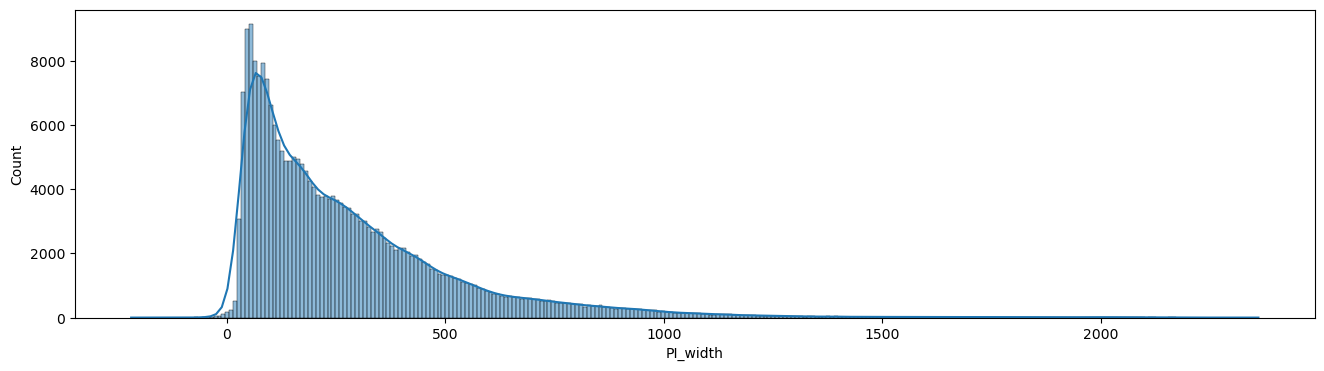

In [16]:
fig, ax = plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'PI_width', kde=True)
plt.show()

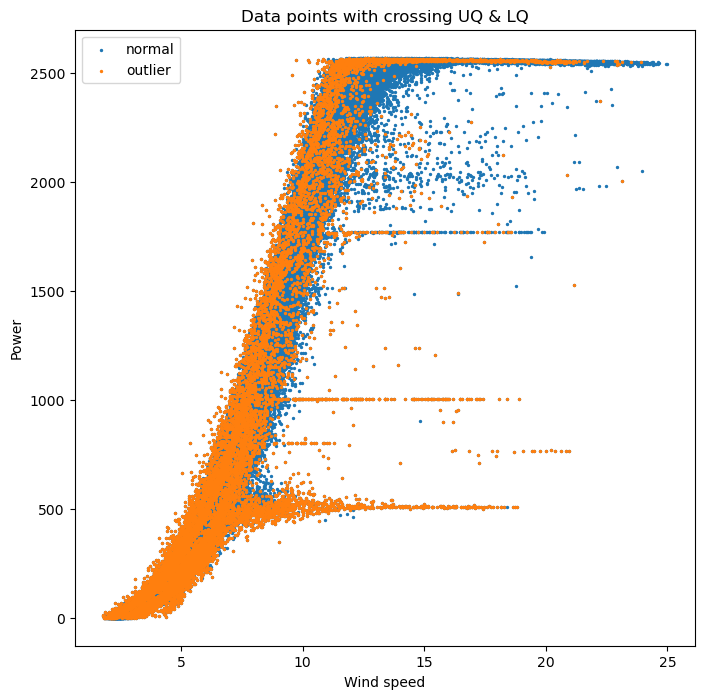

In [17]:
# plot outliers
plt.subplots(figsize = (8,8))
plt.scatter(results_all['Wind_speed'], results_all['Power'], s = 2, label = 'normal')
plt.scatter(outlier_all['Wind_speed'], outlier_all['Power'], s = 2, label = 'outlier')
plt.xlabel('Wind speed')
plt.ylabel('Power')
plt.legend()
plt.title('Data points with crossing UQ & LQ')
plt.show()

#### Mean PI width vs wind speed

In [18]:
print("max wind speed: ", results_all['Wind_speed'].min())
print("max wind speed: ", results_all['Wind_speed'].max())

max wind speed:  1.791111
max wind speed:  24.96704


In [19]:
# define lists to bin the wind speed by 0.5 m/s
Wind_speed_bin = np.linspace(1, 23, 23)
Wind_speed_start = np.linspace(1, 22, 22)
Wind_speed_end = np.linspace(2, 23, 22)
Wind_speed_range = ['1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', 
                    '12-13', '13-14', '14-15', '15-16', '16-17', '17-18', '18-19', '19-20', '20-21', '21-22', '22-23']


In [20]:
PI_windspeed_trends = pd.DataFrame()
for i in range (len(Wind_speed_start)):
    temp_data = results_all[(results_all['Wind_speed'] >= Wind_speed_start[i]) & 
                        (results_all['Wind_speed'] < Wind_speed_end[i])]
    
    sample_count = len(temp_data)
    
    if (sample_count == 0): 
        RMSE = np.nan 
        PI_width_mean = np.nan 
    
    else:
        RMSE = np.sqrt(metrics.mean_squared_error(temp_data['Power'], temp_data['Predicted_power']))
        PI_width_mean = temp_data['PI_width'].mean()
     
    PI_windspeed_trend = pd.DataFrame([Wind_speed_range[i], sample_count, RMSE, PI_width_mean], 
                              index = ['Wind_speed_range', 'Sample_count', 'RMSE', 'PI_width_mean']).T
    if PI_windspeed_trends.empty:
        PI_windspeed_trends = PI_windspeed_trend

    else:
        PI_windspeed_trends = pd.concat([PI_windspeed_trends, PI_windspeed_trend])

PI_windspeed_trends = PI_windspeed_trends.reset_index(drop=True)
        
PI_windspeed_trends   

,Wind_speed_range,Sample_count,RMSE,PI_width_mean
0,1-2,36,20.404535,65.193962
1,2-3,9766,9.457501,47.160126
2,3-4,24529,15.613139,54.560631
3,4-5,28688,25.184869,94.510216
4,5-6,31367,37.781905,138.919357
5,6-7,31836,53.321161,213.237
6,7-8,25985,83.468978,326.106873
7,8-9,20047,125.075694,477.665222
8,9-10,16083,157.308012,533.862915
9,10-11,13196,172.551144,495.385468


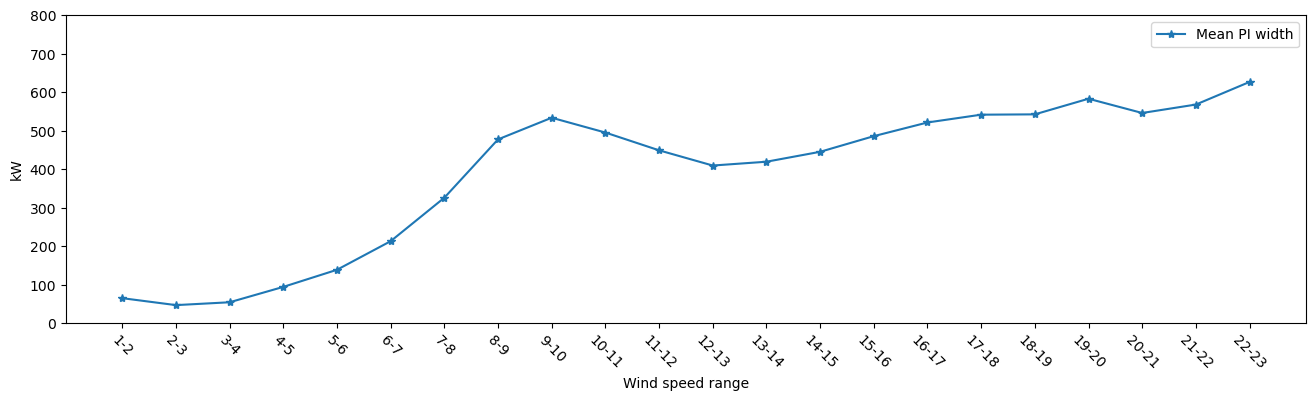

In [21]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(PI_windspeed_trends['PI_width_mean'], label = 'Mean PI width', marker = '*')
ax.axes.set_xticks(ticks = PI_windspeed_trends.index.values)
ax.axes.set_xticklabels(Wind_speed_range)
ax.set_xlabel('Wind speed range')
plt.xticks(rotation = -45)
plt.ylim([0, 800])
plt.ylabel('kW')
# plt.title('Quantile Regression with Artificial Neural Network')
plt.legend()
plt.show()

#### Mean PI width vs TI

In [22]:
print("max TI: ", results_all['TI'].min())
print("max TI: ", results_all['TI'].max())

max TI:  3.717962730543979
max TI:  56.55283271179468


In [23]:
TI_bin = np.linspace(1, 12, 12)
TI_start = np.linspace(0, 55, 12)
TI_end = np.linspace(5, 60, 12)
TI_range = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', 
                    '50-55', '55-60']

In [24]:
PI_TI_trends = pd.DataFrame()
for i in range (len(TI_start)):
    temp_data = results_all[(results_all['TI'] >= TI_start[i]) & 
                        (results_all['TI'] < TI_end[i])]
    
    sample_count = len(temp_data)
    if (sample_count == 0):
        RMSE = np.nan 
        PI_width_mean = np.nan 
    
    else:
        RMSE = np.sqrt(metrics.mean_squared_error(temp_data['Power'], temp_data['Predicted_power']))
        PI_width_mean = temp_data['PI_width'].mean()

    PI_TI_trend = pd.DataFrame([TI_range[i], sample_count, RMSE, PI_width_mean], 
                                  index = ['TI_range', 'Sample_count', 'RMSE', 'PI_width_mean']).T
    if PI_TI_trends.empty:
        PI_TI_trends = PI_TI_trend

    else:
        PI_TI_trends = pd.concat([PI_TI_trends, PI_TI_trend])

PI_TI_trends = PI_TI_trends.reset_index(drop=True)

PI_TI_trends   

,TI_range,Sample_count,RMSE,PI_width_mean
0,0-5,51,67.898204,257.379669
1,5-10,13868,87.126114,282.738098
2,10-15,102062,112.309187,302.151703
3,15-20,80110,128.502799,316.567596
4,20-25,32704,86.126988,200.881393
5,25-30,11038,51.295486,119.682549
6,30-35,3230,25.847849,95.717873
7,35-40,777,22.165069,99.513557
8,40-45,146,28.022583,123.194618
9,45-50,31,21.57704,128.669144


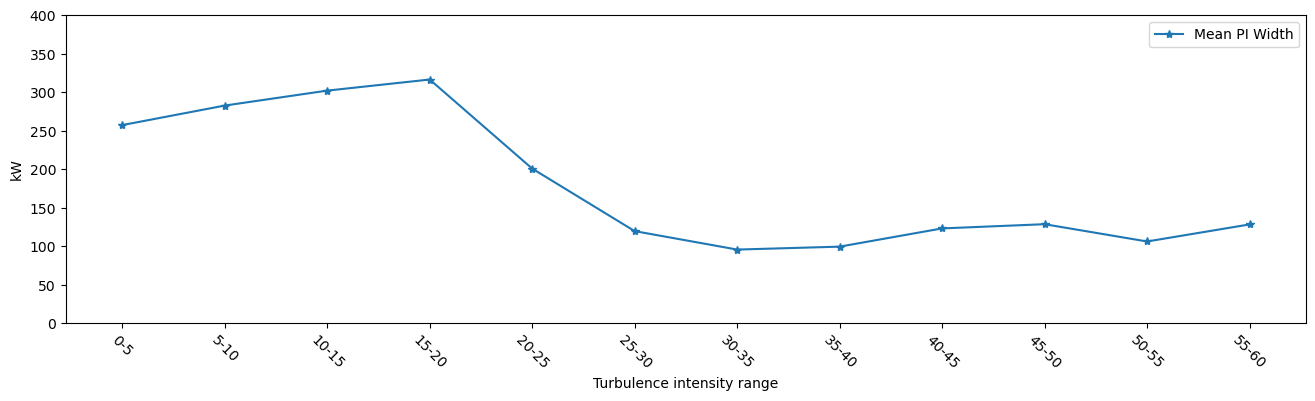

In [25]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(PI_TI_trends['PI_width_mean'], label = 'Mean PI Width', marker = '*')
ax.axes.set_xticks(ticks = PI_TI_trends.index.values)
ax.axes.set_xticklabels(TI_range)
ax.set_xlabel('Turbulence intensity range')
plt.xticks(rotation = -45)
# plt.title('Quantile Regression with Neural Network')
plt.ylabel('kW')
plt.ylim([0, 400])
plt.legend()
plt.show()

#### Mean PI width vs Temperature

In [26]:
print("max temperature: ", results_all['Temperature'].min())
print("max temperature: ", results_all['Temperature'].max())

max temperature:  -0.7026081
max temperature:  26.72089


In [27]:
Temperature_bin = np.linspace(1, 12, 12)
Temperature_start = np.linspace(-2.5, 25, 12)
Temperature_end = np.linspace(0, 27.5, 12)
Temperature_range = ['-2.5-0', '0-2.5', '2.5-5', '5-7.5', '7.5-10', '10-12.5', '12.5-15', '15-17.5', '17.5-20',
                    '20-22.5', '22.5-25', '25-27.5']

In [28]:
error_trends = pd.DataFrame()
for i in range (len(Temperature_start)):
    temp_data = results_all[(results_all['Temperature'] >= Temperature_start[i]) & 
                        (results_all['Temperature'] < Temperature_end[i])]
    
    sample_count = len(temp_data)
    if (sample_count <= 0):
        RMSE = np.nan
        PI_width_mean = np.nan

    else:
        RMSE = np.sqrt(metrics.mean_squared_error(temp_data['Power'], temp_data['Predicted_power']))
        PI_width_mean = temp_data['PI_width'].mean()

    error_trend = pd.DataFrame([Temperature_range[i], sample_count, RMSE, PI_width_mean], 
                              index = ['Temperature_range', 'Sample_count', 'RMSE', 'PI_width_mean']).T
    if error_trends.empty:
        error_trends = error_trend

    else:
        error_trends = pd.concat([error_trends, error_trend])

error_trends = error_trends.reset_index(drop=True)

error_trends   

,Temperature_range,Sample_count,RMSE,PI_width_mean
0,-2.5-0,106,75.552716,362.36557
1,0-2.5,15330,97.395435,297.661133
2,2.5-5,37156,95.742925,287.074066
3,5-7.5,50171,128.924612,321.525574
4,7.5-10,43083,124.440092,335.021332
5,10-12.5,40699,112.779853,228.05368
6,12.5-15,30095,87.316977,226.286942
7,15-17.5,19018,84.107768,248.665771
8,17.5-20,5360,126.356809,246.186096
9,20-22.5,2077,128.746512,155.505981


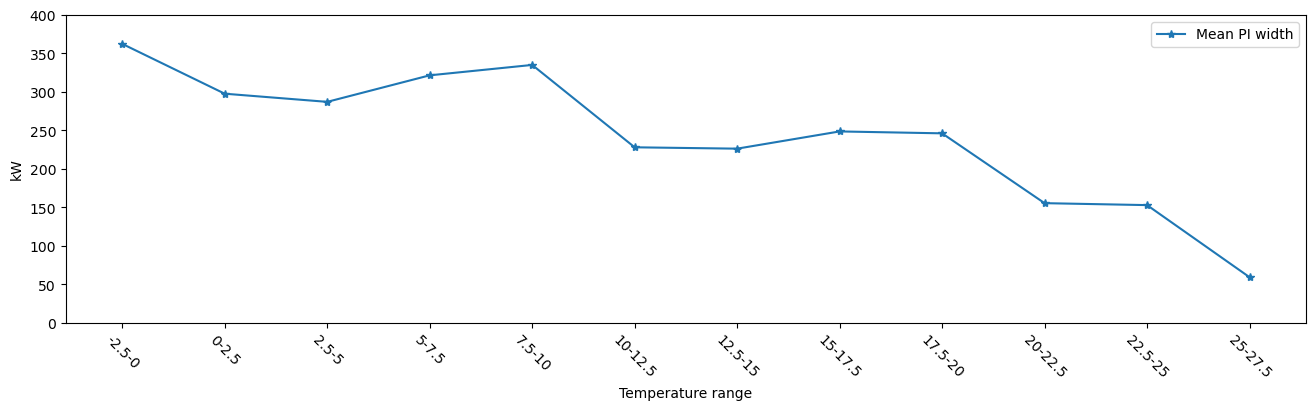

In [29]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(error_trends['PI_width_mean'], label = 'Mean PI width', marker = '*')
ax.axes.set_xticks(ticks = error_trends.index.values)
ax.axes.set_xticklabels(Temperature_range)
ax.set_xlabel('Temperature range')
plt.xticks(rotation = -45)
# plt.title('Quantile Regression with Neural Network')
plt.ylabel('kW')
plt.ylim([0, 400])
plt.legend()
plt.show()

### Create pivot and heatmap

In [15]:
results_all_pivot = pd.pivot_table(results_all, values=['Sample_count', 'Outlier_pred', 'Under_pred', 'Over_pred'], 
                                   index=['instanceID', 'Week'],
                                   aggfunc={'Sample_count': np.sum, 
                                            'Outlier_pred': np.sum, 
                                            'Under_pred': np.sum, 
                                            'Over_pred': np.sum})
results_all_pivot

Outlier_pred  Over_pred  Sample_count  Under_pred
instanceID Week                                                   
A_WTG01    1                2          0           717           2
           2               15          5           754          10
           3               54         25           963          29
           4               33         24           996           9
           5               29          2           861          27
...                       ...        ...           ...         ...
A_WTG06    49               3          3           912           0
           50              20         18           732           2
           51              36         31           987           5
           52              35         34           909           1
           53               5          0           473           5

[306 rows x 4 columns]

In [16]:
# drop rows with insignificant sample count 
min_samples =  252
idx = results_all_pivot[results_all_pivot['Sample_count'] < min_samples].index
results_all_pivot = results_all_pivot.drop(idx)

In [17]:
# define threshold
L0_threshold = 0.1
L1_threshold = 0.2
L2_threshold = 0.3

In [18]:
# assign warning levels
results_all_pivot['Outlier_ratio'] = results_all_pivot['Outlier_pred']/results_all_pivot['Sample_count']
results_all_pivot['Over_ratio'] = results_all_pivot['Over_pred']/results_all_pivot['Sample_count']
results_all_pivot['Under_ratio'] = results_all_pivot['Under_pred']/results_all_pivot['Sample_count']

results_all_pivot['Level_0'] = results_all_pivot['Outlier_ratio'] <= L0_threshold
results_all_pivot['Level_1'] = (results_all_pivot['Outlier_ratio'] > L0_threshold) & (results_all_pivot['Outlier_ratio'] <= L1_threshold)
results_all_pivot['Level_2'] = (results_all_pivot['Outlier_ratio'] > L1_threshold) & (results_all_pivot['Outlier_ratio'] <= L2_threshold)
results_all_pivot['Level_3'] = results_all_pivot['Outlier_ratio'] > L2_threshold

results_all_pivot['Level_0_up'] = results_all_pivot['Over_ratio'] <= L0_threshold/2
results_all_pivot['Level_1_up'] = (results_all_pivot['Over_ratio'] > L0_threshold/2) & (results_all_pivot['Over_ratio'] <= L1_threshold/2)
results_all_pivot['Level_2_up'] = (results_all_pivot['Over_ratio'] > L1_threshold/2) & (results_all_pivot['Over_ratio'] <= L2_threshold/2)
results_all_pivot['Level_3_up'] = results_all_pivot['Over_ratio'] > L2_threshold/2

results_all_pivot['Level_0_lo'] = results_all_pivot['Under_ratio'] <= L0_threshold/2
results_all_pivot['Level_1_lo'] = (results_all_pivot['Under_ratio'] > L0_threshold/2) & (results_all_pivot['Under_ratio'] <= L1_threshold/2)
results_all_pivot['Level_2_lo'] = (results_all_pivot['Under_ratio'] > L1_threshold/2) & (results_all_pivot['Under_ratio'] <= L2_threshold/2)
results_all_pivot['Level_3_lo'] = results_all_pivot['Under_ratio'] > L2_threshold/2

results_all_pivot['Level_combined'] = results_all_pivot['Level_1']*1 + results_all_pivot['Level_2']*2 + results_all_pivot['Level_3']*3
results_all_pivot['Level_combined_up'] = results_all_pivot['Level_1_up']*1 + results_all_pivot['Level_2_up']*2 + results_all_pivot['Level_3_up']*3
results_all_pivot['Level_combined_lo'] = results_all_pivot['Level_1_lo']*1 + results_all_pivot['Level_2_lo']*2 + results_all_pivot['Level_3_lo']*3

In [19]:
results_all_pivot = results_all_pivot.reindex(columns = ['Level_combined', 'Level_combined_up', 'Level_combined_lo'])
results_all_pivot = results_all_pivot.reset_index()

In [20]:
# create dummy rows to ensure all weeks appear in heatmap 
for week in range (1, 54): 
    if results_all_pivot[(results_all_pivot['Week'] == week)].empty: 
        new_row = {'instanceID': site + '_WTG01', 'Week':week, 'Level_combined':np.nan, 'Level_combined_up':np.nan, 
                  'Level_combined_lo':np.nan}
        results_all_pivot = results_all_pivot.append(new_row, ignore_index = True)

In [21]:
results_all_pivot

,instanceID,Week,Level_combined,Level_combined_up,Level_combined_lo
0,A_WTG01,1,0.0,0.0,0.0
1,A_WTG01,2,0.0,0.0,0.0
2,A_WTG01,3,0.0,0.0,0.0
3,A_WTG01,4,0.0,0.0,0.0
4,A_WTG01,5,0.0,0.0,0.0
...,...,...,...,...,...
298,A_WTG06,52,0.0,0.0,0.0
299,A_WTG06,53,0.0,0.0,0.0
300,A_WTG01,46,NaN,NaN,NaN
301,A_WTG01,47,NaN,NaN,NaN


In [37]:
# create separate dataframe for outliers at either/ above UQ/ below LQ
pivot_either = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined')
pivot_up = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined_up')
pivot_lo = results_all_pivot.pivot(index = 'instanceID', columns = 'Week', values = 'Level_combined_lo')

### Heatmap

In [38]:
cat_1 = "Outliers above UQ & below LQ"
cat_2 = "Outliers above UQ"
cat_3 = "Outliers below LQ"

In [39]:
def plot_heatmap(df_pivot, category): 
    
    colors = [(0, 0.85, 0), (1, 1, 0), (1, 0.7, 0), (1, 0, 0)]
    n_bins = 4
    cmap_name = 'cm'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    fig, ax = plt.subplots(figsize = (20,8))
    ax = sns.heatmap(df_pivot, vmin = 0, vmax = 4, annot = True, cmap = cm, cbar = True, 
                linewidths = 1)

    # customize colorbar
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0.5, 1.5, 2.5, 3.5])
    colorbar.set_ticklabels([0, 1, 2, 3])
    
    plt.yticks(rotation=0) 
    plt.title(category)
    plt.show()

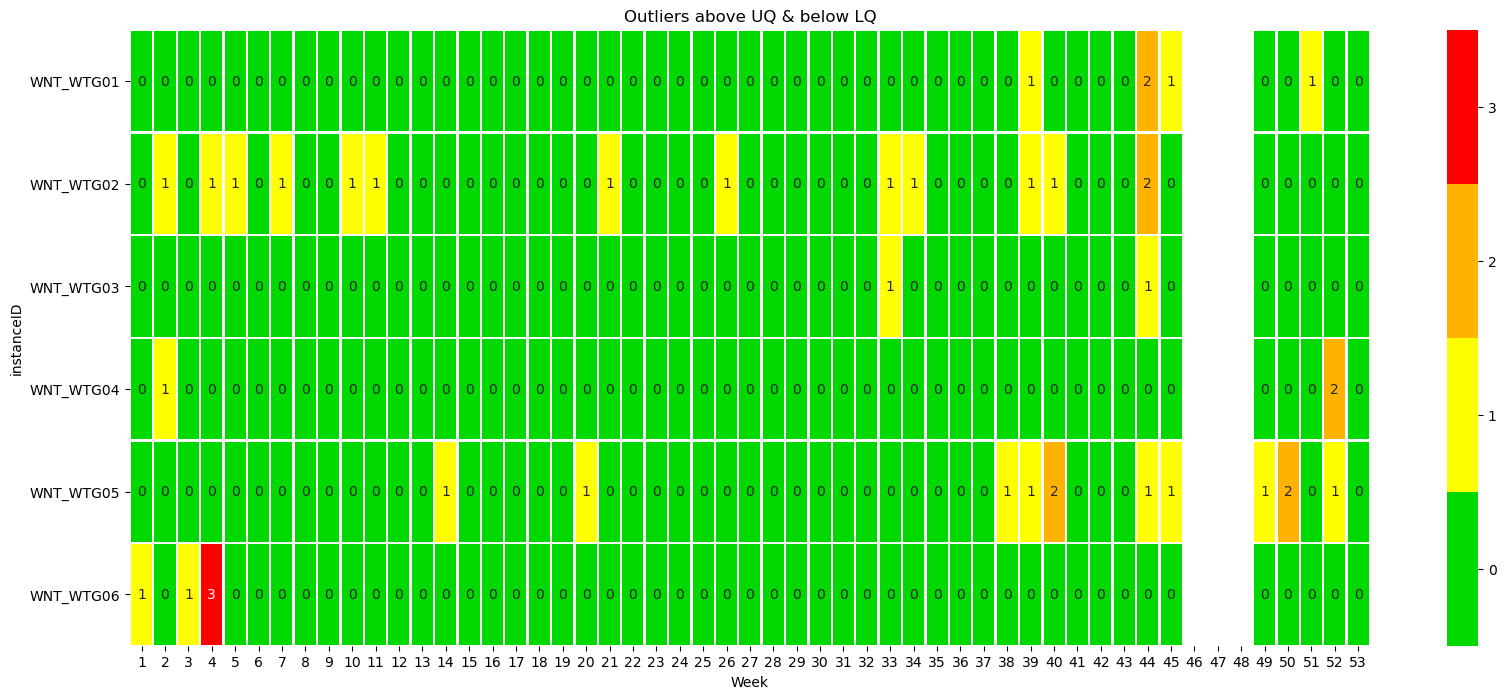

In [40]:
plot_heatmap(pivot_either, cat_1)

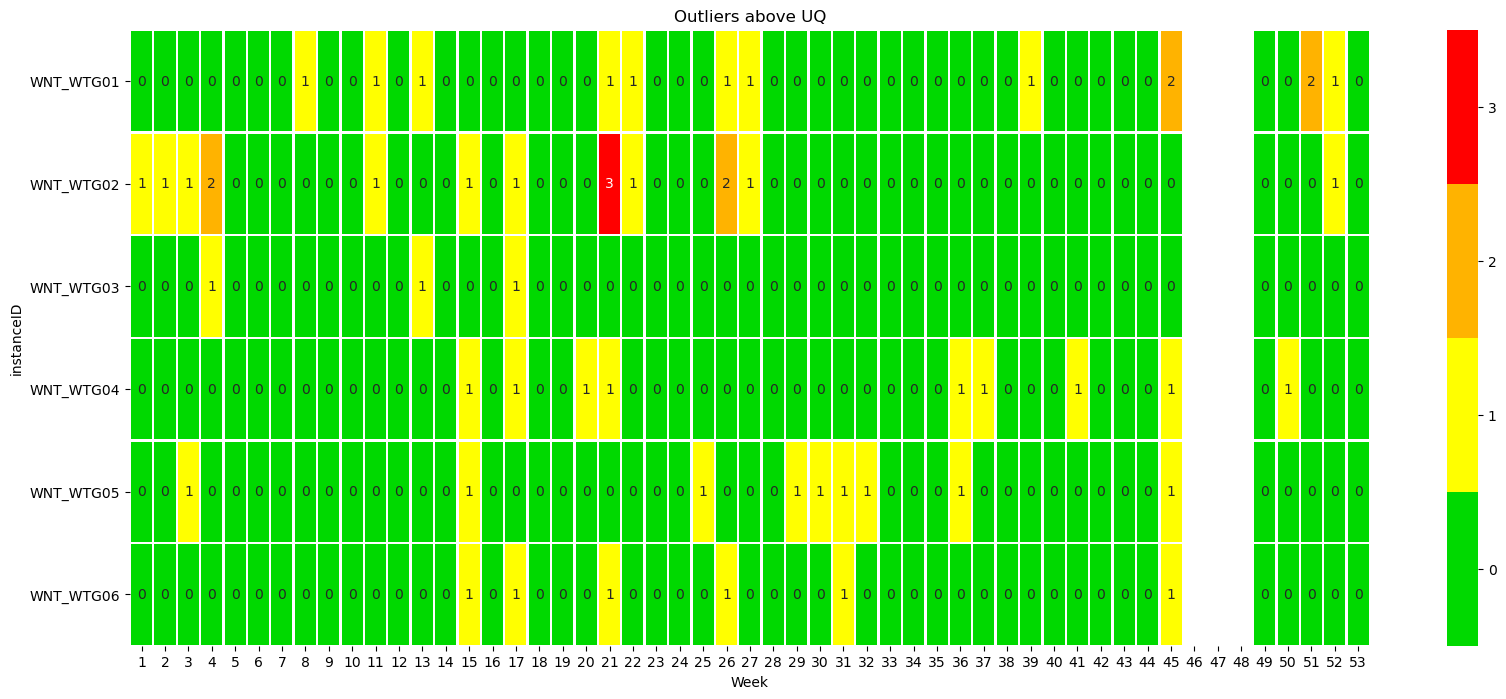

In [41]:
plot_heatmap(pivot_up, cat_2)

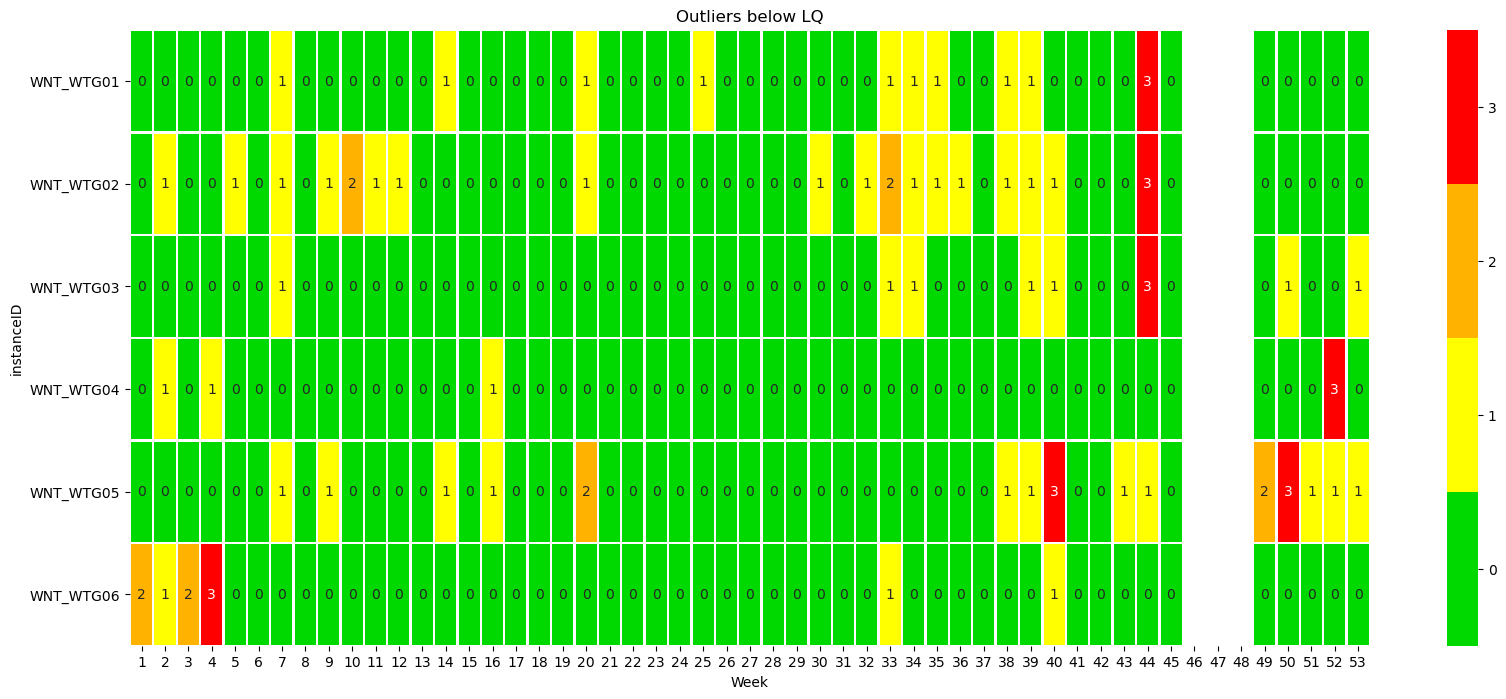

In [42]:
plot_heatmap(pivot_lo, cat_3)

### Plots 

In [22]:
# define function to plot time series
def plot_time(df_target, df_outlier, turbine, week):
    fig, ax = plt.subplots(figsize = (16, 4))
    ax.plot(df_target['ts'], df_target['Power'], label = 'Measured power')
    ax.plot(df_target['ts'], df_target['UQ'], label = 'UQ')
    ax.plot(df_target['ts'], df_target['LQ'], label = 'LQ')
    ax.scatter(df_outlier['ts'], df_outlier['Power'], color = 'red', label = 'outlier')
    plt.xlabel('Time')
    plt.ylabel('Power, kW')
    plt.title(site + '_WTG' + turbine + ' Week ' + str(week))
    plt.legend()
    plt.show()

In [23]:
# define function to plot power curve
def plot_pcurve(df_turbine, df_target, df_outlier, turbine, week):
    
    colors = np.array([(0.70, 0.85, 1), (0, 0.40, 0.80), (0.80, 0, 0)])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))
    
    ax1.scatter(df_turbine['Wind_speed'], df_turbine['Power'], s = 2, label = site + '_WTG' + turbine, 
                color = colors[0])
    ax1.scatter(df_target['Wind_speed'], df_target['Power'], s = 5, label = 'Week ' + str(week), 
                color = colors[1])
    ax1.set_xlabel('Wind speed, m/s')
    ax1.set_ylabel('Power, kW')
    ax1.legend(loc = 'lower right')
    ax1.grid()
    
    ax2.scatter(df_turbine['Wind_speed'], df_turbine['Power'], s = 2, label = site + "_WTG" + turbine, 
                color = colors[0])
    ax2.scatter(df_outlier['Wind_speed'], df_outlier['Power'], s = 5, label = 'Week ' + str(week) + ' Outlier', 
                color = colors[2])
    ax2.set_xlabel('Wind speed, m/s')
    ax2.set_ylabel('Power, kW')
    ax2.legend(loc = 'lower right')
    ax2.grid()
    plt.show()

In [24]:
def plot_variables (df_turbine, df_target, df_outlier, turbine, week):
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['Temperature'])
    plt.scatter(df_outlier['ts'], df_outlier['Temperature'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('Temperature')
    plt.ylim((df_turbine['Temperature'].min(), df_turbine['Temperature'].max()))
    plt.ylabel('Temperature')
    plt.legend()
    
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['TI'])
    plt.scatter(df_outlier['ts'], df_outlier['TI'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('TI')
    plt.ylim((df_turbine['TI'].min(), df_turbine['TI'].max()))
    plt.ylabel('TI')
    plt.legend()
    
    plt.subplots(figsize = (16, 2))
    plt.plot(df_target['ts'], df_target['Wind_speed'])
    plt.scatter(df_outlier['ts'], df_outlier['Wind_speed'], label = 'Week ' + str(week) + ' Outlier', 
                color = 'red')
    plt.title('Wind speed')
    plt.ylim((df_turbine['Wind_speed'].min(), df_turbine['Wind_speed'].max()))
    plt.ylabel('Wind speed')
    plt.legend()
    
    plt.show()

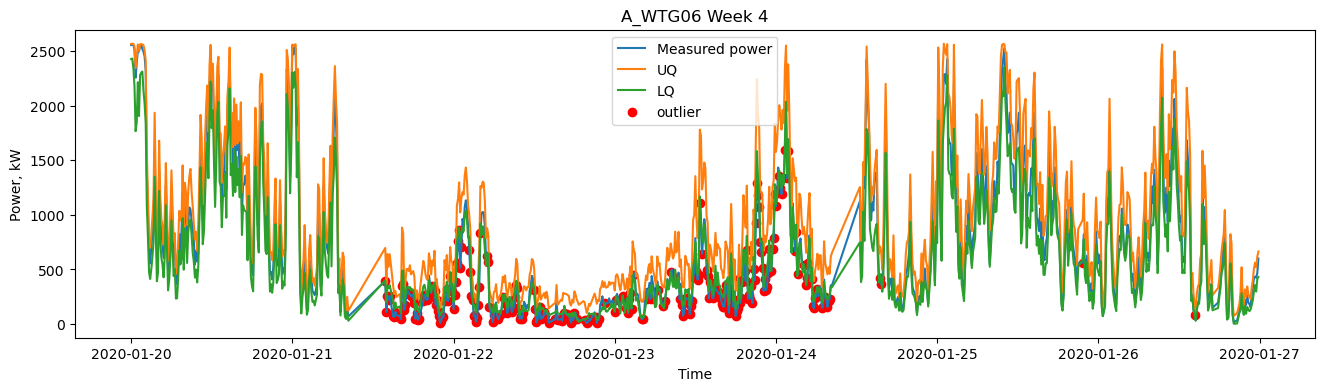

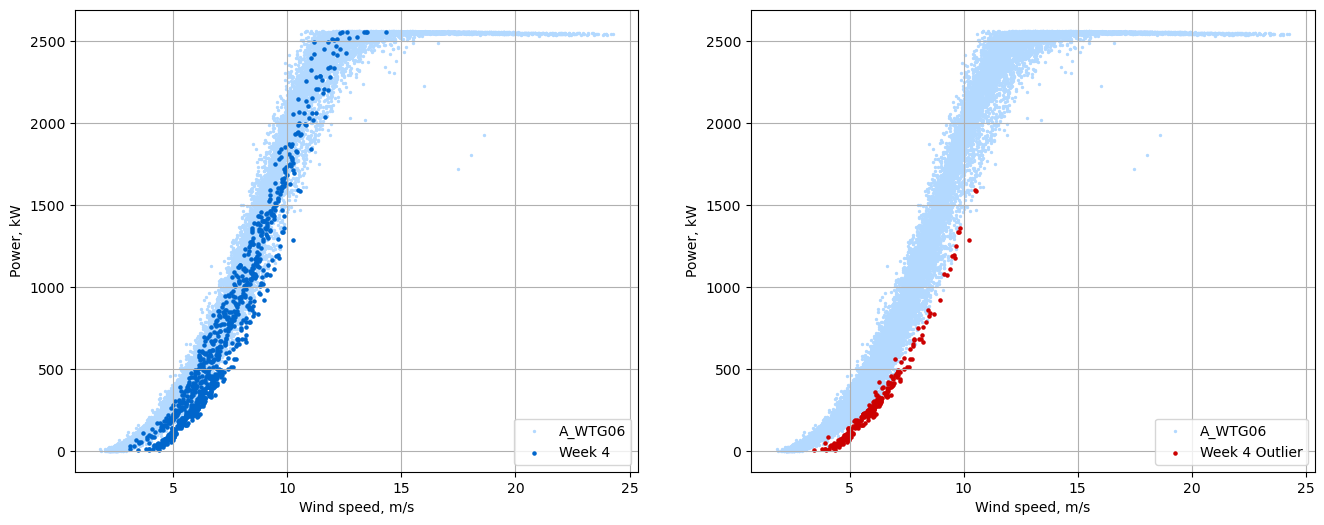

In [27]:
# select turbine number and week number to plot
turbine = "06"
week = 4

# create dataframe for plots
df_turbine = results_all[(results_all['instanceID'] == site + "_WTG" + turbine)]

df_target = df_turbine[(df_turbine['Week'] == week)]
df_outlier = df_target[df_target['Outlier_pred'] >= 1]

# plot
plot_time(df_target, df_outlier, turbine, week)
# plot_variables(df_turbine, df_target, df_outlier, turbine, week)
plot_pcurve(df_turbine, df_target, df_outlier, turbine, week)

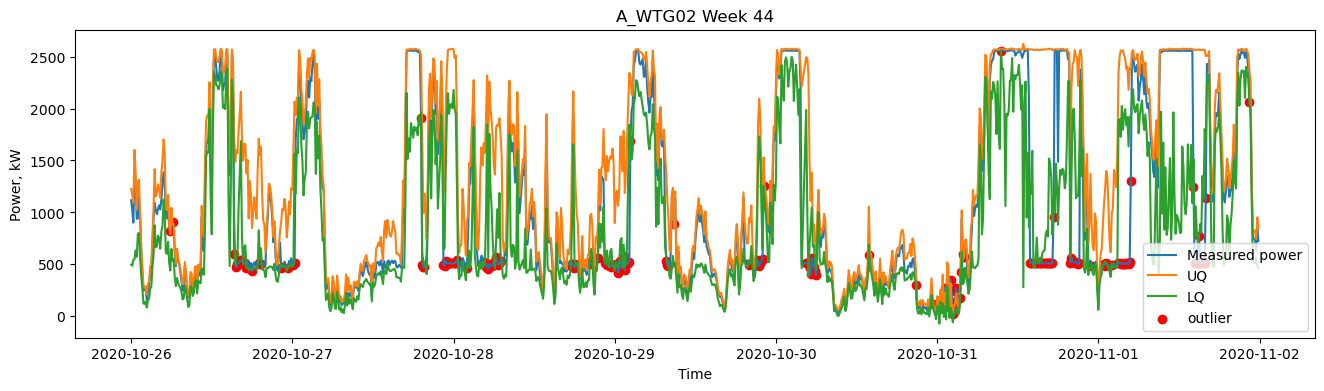

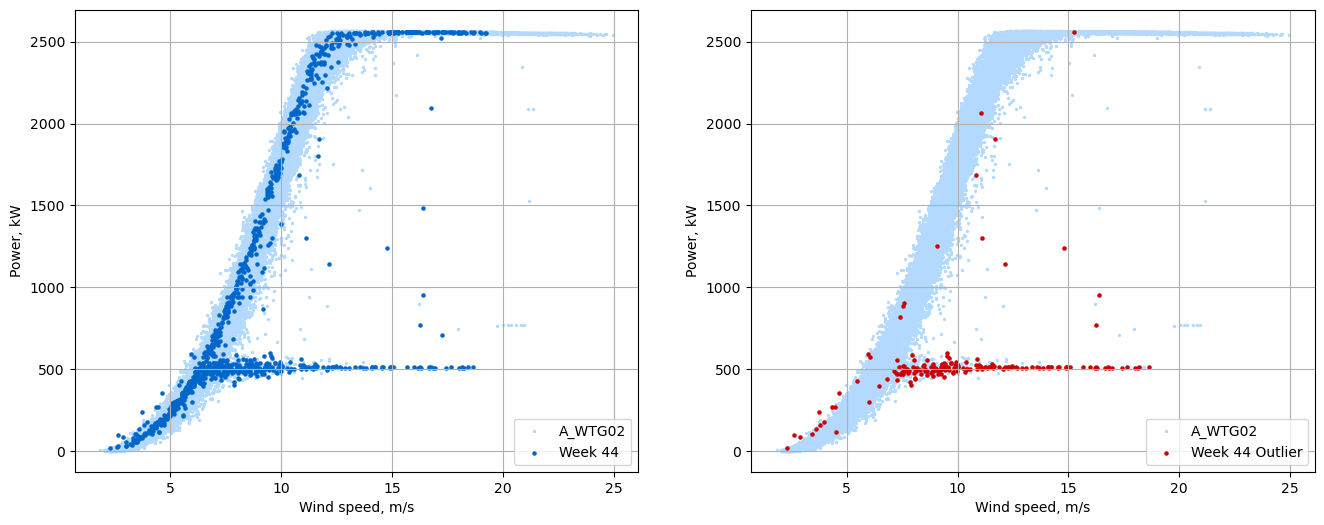

In [28]:
# select turbine number and week number to plot
turbine = "02"
week = 44

# create dataframe for plots
df_turbine = results_all[(results_all['instanceID'] == site + "_WTG" + turbine)]

df_target = df_turbine[df_turbine['Week'] == week]
df_outlier = df_target[df_target['Outlier_pred'] >= 1]

# plot
plot_time(df_target, df_outlier, turbine, week)
# plot_variables(df_turbine, df_target, df_outlier, turbine, week)
plot_pcurve(df_turbine, df_target, df_outlier, turbine, week)

### Heteroschedascticity

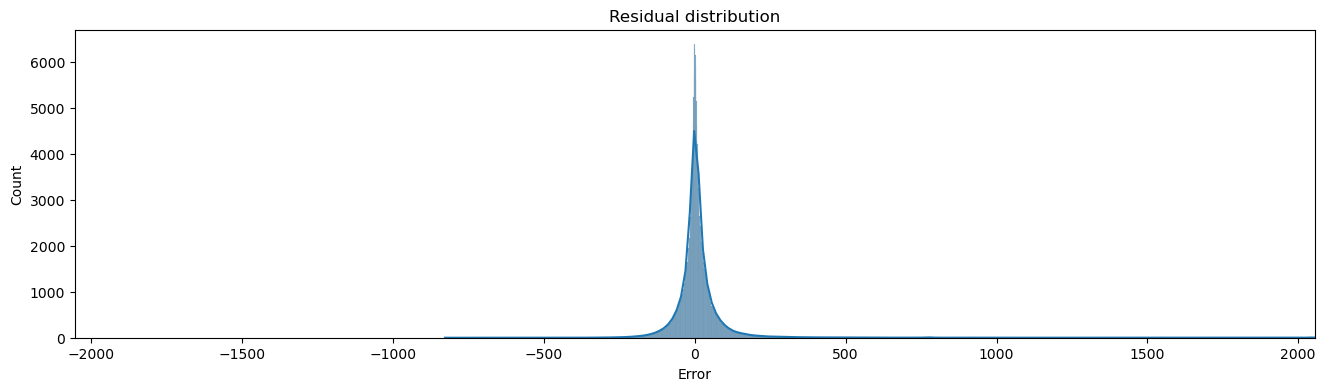

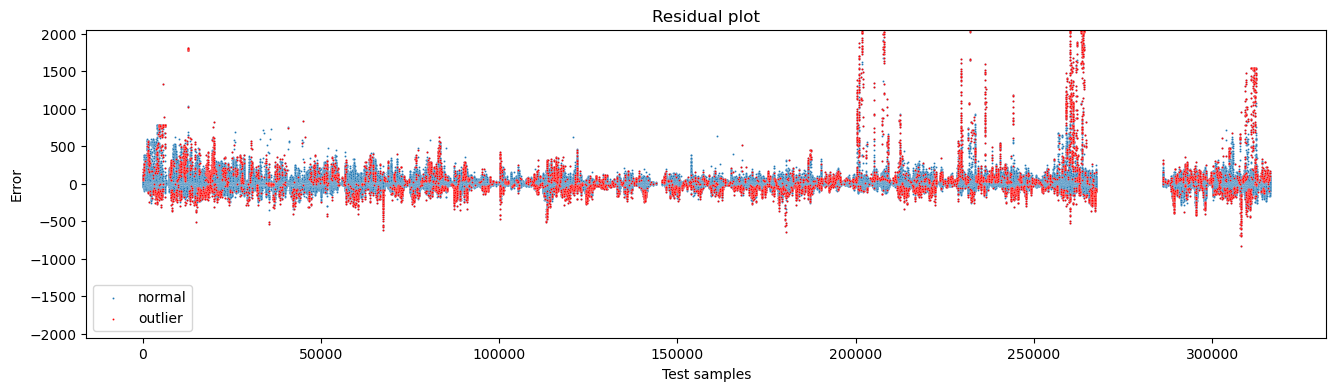

In [29]:
plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'Error', kde = True)
plt.xlim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.title('Residual distribution')
plt.show()

temp = results_all[results_all['Outlier_pred'] == 1]
plt.subplots(figsize = (16,4))
sns.scatterplot(data = results_all, x = results_all.index.values, y = results_all['Error'], s=2, label = 'normal')
sns.scatterplot(data = temp, x = temp.index.values, y = temp['Error'], color = 'red', s=2, label = 'outlier')
plt.ylim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.xlabel('Test samples')
plt.title('Residual plot')
plt.legend()
plt.show()


In [30]:
temp_data = results_all[results_all['instanceID'] == site + '_WTG01']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

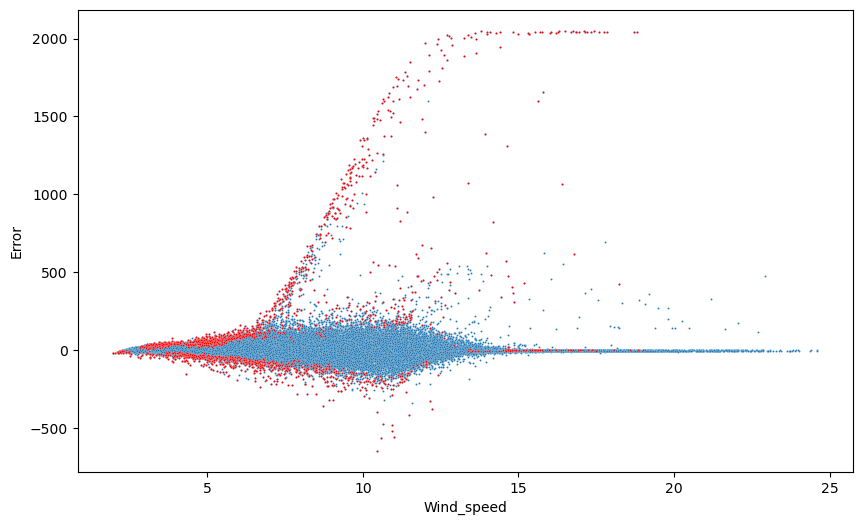

In [36]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Wind_speed", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "Wind_speed", y = "Error", s = 2, color = "red")
# plt.ylim([-700, 700])
plt.show()

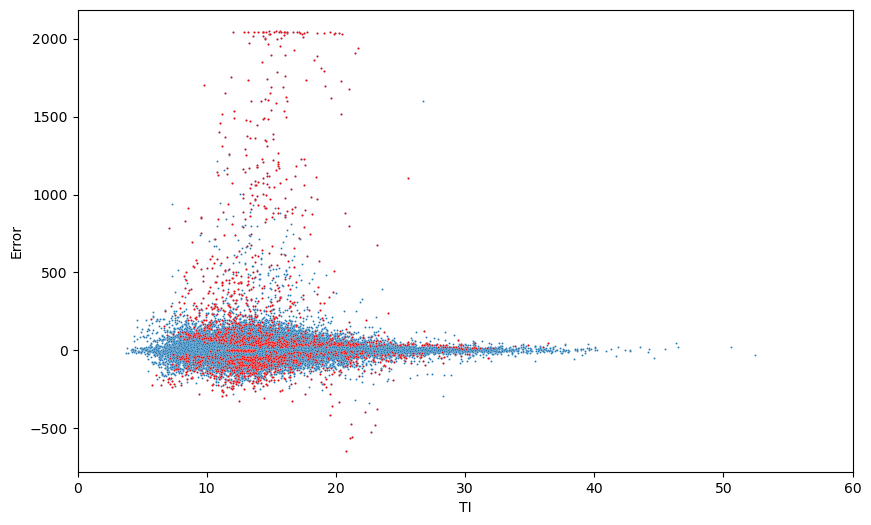

In [37]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "TI", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "TI", y = "Error", s = 2, color = "red")
# plt.ylim([-700, 700])
plt.xlim([0, 60])
plt.show()

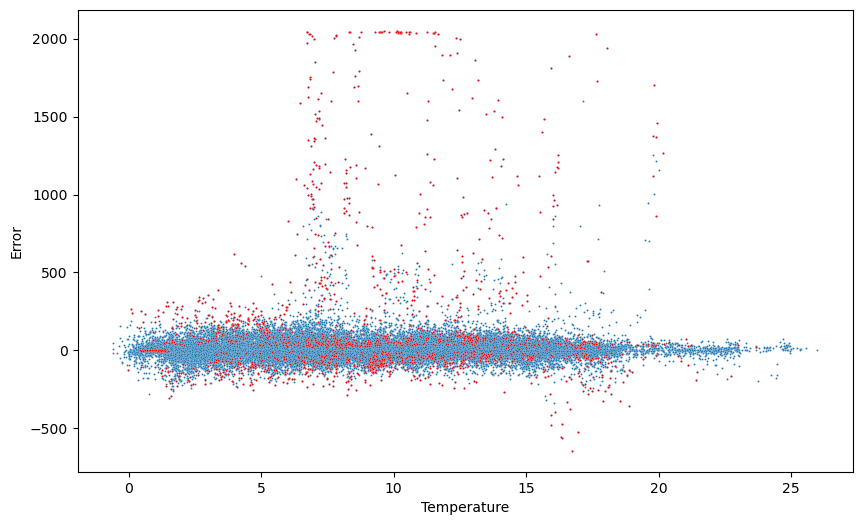

In [38]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Temperature", y = 'Error', s = 2)
sns.scatterplot(data = temp_outlier, x = "Temperature", y = 'Error', s = 2, color = "red")
# plt.ylim([-700, 700])
plt.show()